In [11]:
from gensim.models import Doc2Vec
from sklearn import decomposition
from sklearn.linear_model import LogisticRegression
import numpy as np  
import sys
from sklearn import metrics
from sklearn import preprocessing
from sklearn.manifold import TSNE

import operator
import heapq

import pandas as pd
import random as rnd
from random import shuffle

from twitch import commons

%pylab inline
matplotlib.use('Agg')
import matplotlib as mpl
import matplotlib.pyplot as plt

# fig_size = plt.rcParams["figure.figsize"]
# fig_size[0] = 12
# fig_size[1] = 9
# plt.rcParams["figure.figsize"] = fig_size

import matplotlib.pylab as pylab

# params = {'legend.fontsize': 'xx-large',
#           'axes.labelsize': 'xx-large',
#           'axes.titlesize': 'xx-large',
#           'xtick.labelsize': 'xx-large',
#           'ytick.labelsize': 'xx-large'}

# pylab.rcParams.update(params)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy
//anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
docvec_ids = [line.strip().split(',')[0] for line in open('../female_channels.csv', 'r')]  + [line.strip().split(',')[0] for line 
                                                                       in open('../male_channels.csv', 'r')]
print(len(docvec_ids))

400


In [4]:
df_list = []
female_channels = [line.strip().split(',')[0] for line in open('../female_channels.csv', 'r')]
male_channels = [line.strip().split(',')[0] for line in open('../male_channels.csv', 'r')]
for docvec_id in docvec_ids:
    channel = docvec_id
    if channel in female_channels:
        channel_type = 1
        channel_rank = female_channels.index(channel)
        quartile = (channel_rank//50) + 1
        if channel_rank < 100:
            color=1
        else:
            color=2
    else :
        channel_type = 0
        channel_rank = male_channels.index(channel)
        quartile = (channel_rank//50) + 1
        if channel_rank < 100:
            color=3
        else:
            color=4
        
    df_list.append((docvec_id, channel, channel_type, channel_rank, quartile, color)) 

print(len(df_list))

400


In [5]:
shuffle(df_list)
channel_df = pd.DataFrame(df_list, columns=['docvec_index', 'channel', 'gender', 'channel_rank', 'quartile', 'color'])

gender_list = channel_df.gender.values.tolist()
quartile_list = channel_df.quartile.values.tolist()
color_list =channel_df.color.values.tolist()
rank_list = channel_df.channel_rank.values.tolist()

In [6]:
model = Doc2Vec.load('./channel_all_chats.d2v')

In [7]:
non_normalized_feature_vectors = [model.docvecs[x] for x in channel_df.docvec_index.values.tolist()]

feature_vectors = preprocessing.normalize(preprocessing.scale(non_normalized_feature_vectors))

In [8]:
no_of_channels = len(feature_vectors)
print(no_of_channels)

400


### classification model

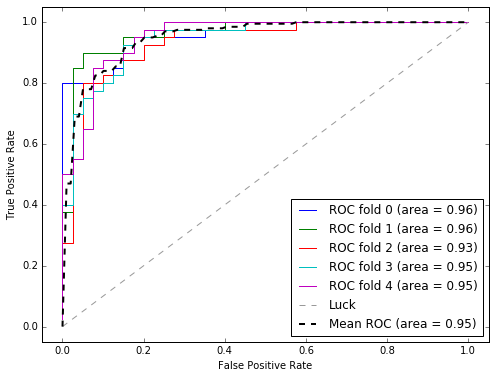

Accuracy: 0.86 (+/- 0.03)


In [8]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

y = np.array(gender_list)
(lr, coef, _) = commons.build_lr_classification_model_cv(feature_vectors, y, 5)

In [11]:
all_words_dic = commons.read_word_count_file("../../data/word_counts/global_word_counts.csv")
all_words_list = sorted(all_words_dic.items(), key=operator.itemgetter(1), reverse=True)

selected_word_vectors = []
selected_words = []
count = 0
for w in all_words_list:
    if count < 1000:
        try:
            selected_word_vectors.append(model[w[0]])
            selected_words.append(w)
            count += 1
        except:
            continue
    else:
        break
selected_word_vectors = preprocessing.normalize(preprocessing.scale(selected_word_vectors))

In [12]:
word_similarity_dic = {}
for i,w in enumerate(selected_words):
    try:
        word_similarity_dic[w[0]] = lr.predict_proba(selected_word_vectors[i].reshape(1, -1))[0][1]
    except:
        continue
        
top_female_words = heapq.nlargest(25, word_similarity_dic, key=word_similarity_dic.get)
print(', '.join(top_female_words))

print('')

top_male_words = heapq.nsmallest(25, word_similarity_dic, key=word_similarity_dic.get)
print(', '.join(top_male_words))

beautiful, cute, omg, love, boobs, hot, show, say, hi, hair, sexy, eyes, speak, hello, pls, cat, xd, hola, nice, ya, am, plz, talk, sleep, here

run, items, instead, system, hit, second, once, takes, dlc, times, atm, gear, anyone, beat, final, worth, save, reason, thinking, still, easy, using, start, speed, any


### clustering

In [36]:
cluster_sample_size = 400
# cluster_xy_vectors = commons.reduce_dim(feature_vectors[0:cluster_sample_size], 'tsne')
cluster_xy_vectors = TSNE(n_components=2, verbose=2, perplexity=10).fit_transform(feature_vectors[0:cluster_sample_size])

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 0.340263
[t-SNE] Iteration 25: error = 1.9578382, gradient norm = 0.0333208
[t-SNE] Iteration 50: error = 1.7297095, gradient norm = 0.0279724
[t-SNE] Iteration 75: error = 1.4267890, gradient norm = 0.0227265
[t-SNE] Iteration 100: error = 1.7007090, gradient norm = 0.0244385
[t-SNE] Error after 100 iterations with early exaggeration: 1.700709
[t-SNE] Iteration 125: error = 1.5354292, gradient norm = 0.0210207
[t-SNE] Iteration 150: error = 1.9812325, gradient norm = 0.0269318
[t-SNE] Iteration 175: error = 2.4372823, gradient norm = 0.0266912
[t-SNE] Iteration 175: did not make any progress during the last 30 episodes. Finished.
[t-SNE] Error after 175 iterations: 2.437282


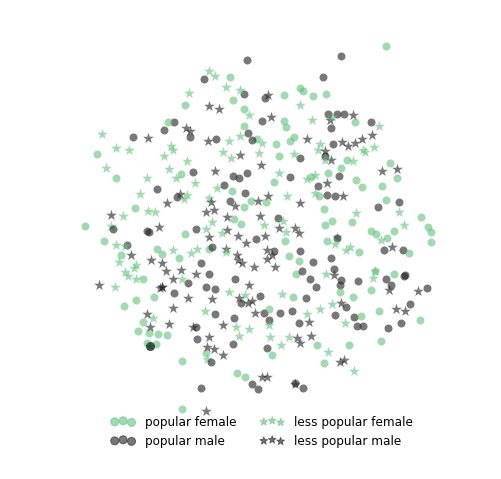

In [37]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

for i in range(400):
    if color_list[i] == 1:
        plt.scatter([cluster_xy_vectors[i][0]], [cluster_xy_vectors[i][1]], s=64, c='#63c17e', lw=0, alpha=0.6)
    elif color_list[i] == 2:
        plt.scatter([cluster_xy_vectors[i][0]], [cluster_xy_vectors[i][1]], s=128, c='#63c17e', lw=0, alpha=0.6,
                   marker='*')
    elif color_list[i] == 3:
        plt.scatter([cluster_xy_vectors[i][0]], [cluster_xy_vectors[i][1]], s=64, c='#1f1f1f', lw=0, alpha=0.6)
    elif color_list[i] == 4:
        plt.scatter([cluster_xy_vectors[i][0]], [cluster_xy_vectors[i][1]], s=128, c='#1f1f1f', lw=0, alpha=0.6,
                   marker='*')

plt.scatter([-50], [-50], s=64, color='#63c17e' , lw=1, label='popular female', alpha=0.6)
 
plt.scatter([-50], [-50], s=64, color='#1F1F1F', lw=1, label='popular male', alpha=0.6)

plt.scatter([-50], [-50], s=64, color='#63c17e' , lw=1, label='less popular female',
            alpha=0.6, marker='*')
 
plt.scatter([-50], [-50], s=64, color='#1F1F1F', lw=1, label='less popular male',
            alpha=0.6, marker='*')

leg = plt.legend(loc='lower center', ncol=2)
leg.draw_frame(False)
plt.axis('off')
plt.draw()
plt.savefig('channel_clusters.svg', format='svg')